In [284]:
import networkx as nx
import osmnx as ox
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import xml.etree.ElementTree as ET
import numpy as np
import os
from tqdm import tqdm
from heapq import heappush, heappop
from collections import defaultdict
import time

ox.settings.useful_tags_way = ['name','higway' ]
ox.settings.useful_tags_node = ['name']
np.set_printoptions(suppress=True)

path = '../output/'

In [2]:
def build_graph_from_osm_file(osm_file_path = '../data/all.osm', retain_all=True, simplify=False):
    graph = ox.graph_from_file(osm_file_path, retain_all=retain_all, simplify=simplify)
    return graph

In [3]:
def get_object_ids(object_type, osm_file_path='../data/all.osm', object_category='amenity'):
    root = ET.parse(osm_file_path).getroot()
    nodes = root.findall('./way')

    res_list = []

    for node in nodes:
        refs_list = []
        tags_list = []
        for child in node:
            if 'ref' in list(child.attrib.keys()):
                refs_list.append(int(child.attrib['ref']))
            else:
                tags_list.append({'key':child.attrib['k'], 'value':child.attrib['v']})
        for el in tags_list:
            if el['key'] ==object_category and el['value']==object_type:
                res_list.append(np.random.choice(refs_list))
    return list(set(res_list))

In [4]:
def get_object_ids_wrapper():
    health_list = get_object_ids(object_category='healthcare', object_type='hospital')
    ed_list = get_object_ids(object_type='school')
    shops_list = get_object_ids(object_type='mall')
    obj_list = health_list + ed_list + shops_list
    apts_list = get_object_ids(object_category='building', object_type='apartments')
    detached_list = get_object_ids(object_category='building', object_type='detached')
    
    nodes_list = apts_list + detached_list
    
    obj_list_filtered = np.random.choice(obj_list, 10, replace=False)
    nodes_list_filtered = np.random.choice(nodes_list, 100, replace=False)
    
    return set(obj_list_filtered), set(nodes_list_filtered)

In [5]:
def get_higway_points(osm_file_path='../data/all.osm'):
        root = ET.parse(osm_file_path).getroot()
        nodes = root.findall('./way')
        res_list = []
        for node in nodes:
            refs_list = []
            tags_list = []
            for child in node:
                if 'ref' in list(child.attrib.keys()):
                    refs_list.append(int(child.attrib['ref']))
                else:
                    tags_list.append({'key':child.attrib['k'], 'value':child.attrib['v']})
            for el in tags_list:
                if el['key'] =='highway':
                    res_list.append(refs_list)
        res_list = [point for sublist in res_list for point in sublist]
        return(res_list)

In [6]:
def corrected_objects(graph, objects_list, points_list):
    simp_dict = dict(graph.nodes(data=True))
    df_obj = pd.DataFrame({node:simp_dict[node] for node in objects_list if node in simp_dict}).T.to_numpy()
    df_points = pd.DataFrame({node:simp_dict[node] for node in points_list if node in simp_dict}).T.drop(columns=['name']).to_numpy()
    
    res_dict = {}
    
    
    for i in range(len(df_obj)):
        min_distance = 10000000000
        for j in range(len(df_points)):
            curr_dist = np.linalg.norm(df_obj[i][:2] - df_points[j][:2])
            if curr_dist < min_distance:
                min_distance = curr_dist
                nearest_point_id = int(df_points[j][2])
                res_dict[int(df_obj[i][2])] = nearest_point_id
    return list(res_dict.values())

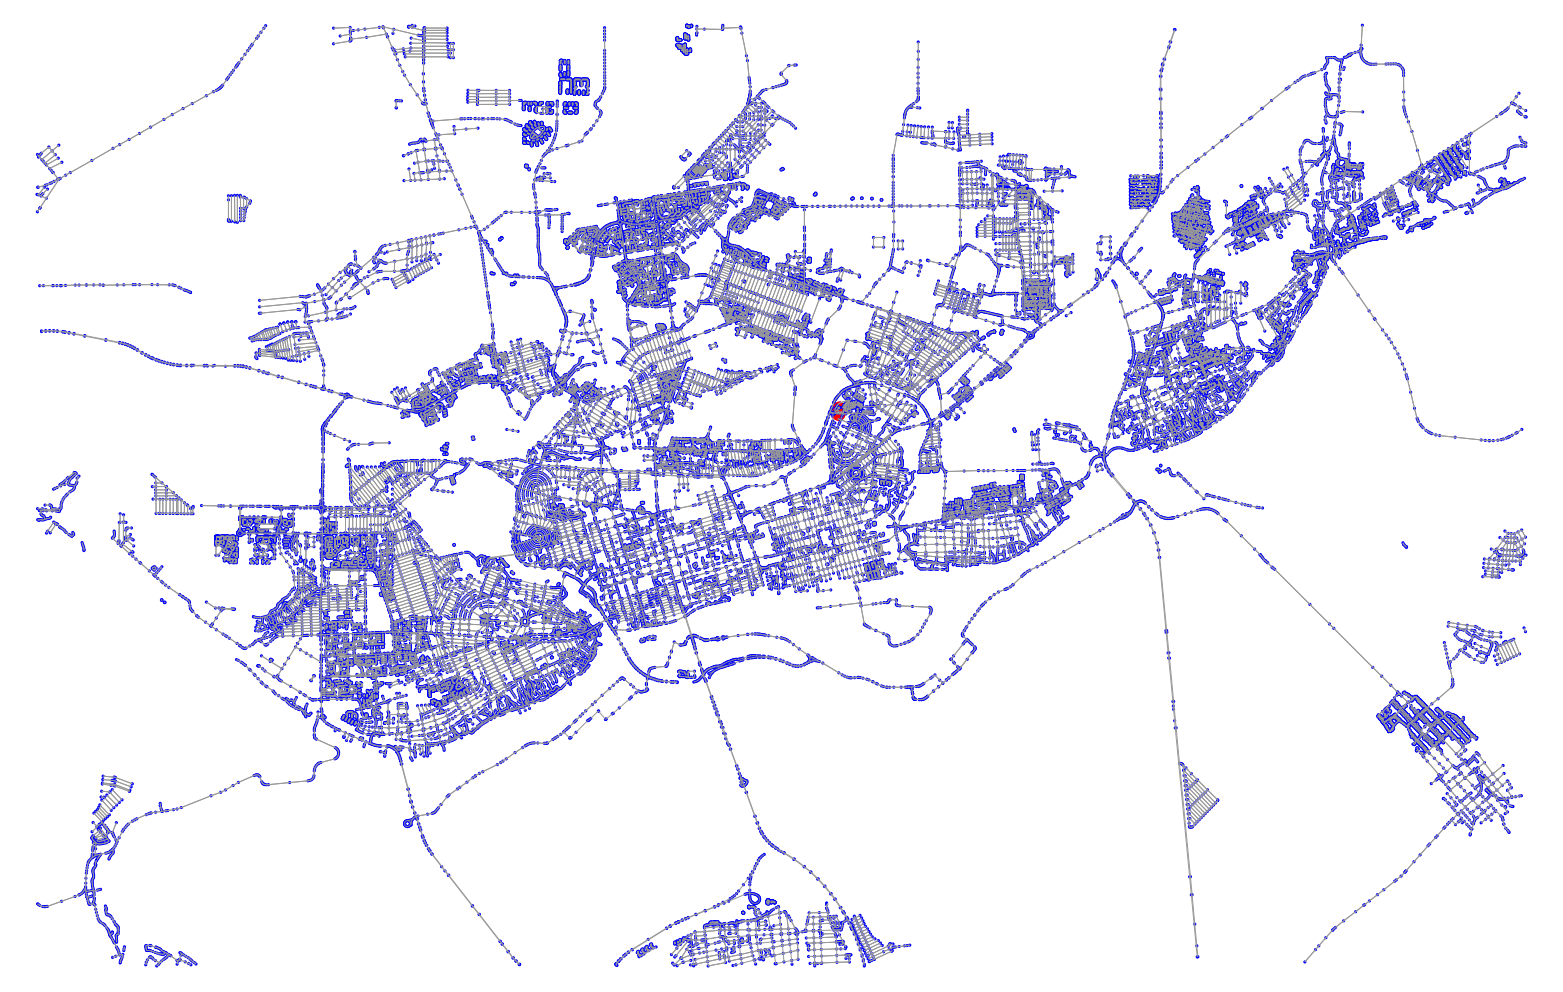

In [189]:
oc = ['r' if node in [1686036641,1569485235] else 'b' for node in list(G.nodes)]
os = [200 if node in [1686036641,1569485235] else 10 for node in list(G.nodes)]
fig, ax = ox.plot_graph(G, node_color = oc, node_size=os, fig_height=18)

In [183]:
def get_resulting_graph(graph, objects_list, nodes_list, visualize, strong_components=False):
    graph_simp = ox.simplify.simplify_graph(graph)
    print(len(nodes_list))
    
    graph_dict = dict(graph.nodes(data=True))
    df_obj = pd.DataFrame({node:graph_dict[node] for node in objects_list if node in graph_dict}).T
    print('Nodes number be4 adding:', len(graph_simp.nodes))
    print('df_obj:', len(df_obj))
    df_nodes = pd.DataFrame({node:graph_dict[node] for node in nodes_list if node in graph_dict}).T
    print('df_nodes:', len(df_nodes))
    for simp_path in ox.simplify.get_paths_to_simplify(graph):
        for osmid in simp_path:
            argwhere = np.argwhere(df_obj['osmid'].to_numpy() == osmid)
            if argwhere.size > 0 and osmid not in list(graph_simp.nodes):
                i = argwhere[0][0]
                obj_node = df_obj.iloc[i].to_dict()
                graph_simp.add_node(osmid, **obj_node)
                graph_simp.add_edge(simp_path[0], osmid)
                graph_simp.add_edge(osmid, simp_path[-1])
                   
                
    print('Nodes number after objects adding:',len(graph_simp.nodes))
    print('Objects inters:', len(set(objects_list).intersection(set(graph_simp.nodes()))))
                
    for simp_path in ox.simplify.get_paths_to_simplify(graph):
        for osmid in simp_path:
            argwhere = np.argwhere(df_nodes['osmid'].to_numpy() == osmid)
            if argwhere.size > 0 and osmid not in list(graph_simp.nodes):
                i = argwhere[0][0]
                obj_node = df_nodes.iloc[i].to_dict()
                graph_simp.add_node(osmid, **obj_node)
                graph_simp.add_edge(simp_path[0], osmid)
                graph_simp.add_edge(osmid, simp_path[-1])
        
    print('Nodes number after nodes adding:',len(graph_simp.nodes))
    print('Nodes inters:', len(set(nodes_list).intersection(set(graph_simp.nodes()))))
    
    if strong_components:
        for component in list(nx.strongly_connected_components(graph_simp)):
            if len(component)<100:
                for node in component:
                    to_remove = []
                    if node not in (nodes_list + objects_list):
                        to_remove.append(node)
                    else:
                        break
                    graph_simp.remove_nodes_from(to_remove)

    print(len(graph_simp.nodes))
                
    if visualize:
        oc = ['r' if osmid in objects_list else 'g' if osmid in nodes_list
              else 'b' for osmid in graph_simp.nodes()]
        os = [200 if osmid in objects_list or osmid in nodes_list   
              else 10 for osmid in graph_simp.nodes()]
        fig, ax = ox.plot_graph(graph_simp, node_color = oc, node_size=os, fig_height=18)
        plt.savefig(path+'Overall_nodes.png')
        
        
        pos = {}
        for key in list(graph_dict.keys()):
            pos[key] = (graph_dict[key]['x'], graph_dict[key]['y'])
        labels = {}
        for i in range(len(objects_list)):
            labels[objects_list[i]] = 'O' + str(i)
        for j in range(len(nodes_list)):
            labels[nodes_list[j]] = 'N' + str(j)
        plt.figure(figsize=(30,18))    
        nc = ['r' if nid in objects_list else 'g' for nid in objects_list + nodes_list]
        nx.draw_networkx(G, pos=pos, nodelist=objects_list + nodes_list, node_color=nc, with_labels=False, arrows=False, node_size=350, edge_color='gray')
        nx.draw_networkx_labels(G,pos=pos, labels=labels, font_size=10)
        plt.savefig(path+'Chosen_nodes_and_objects.png')
        

    return graph_simp

In [13]:
def init_weights(graph, objects_list):
    weight_factor = 1.5
    for obj_id in objects_list:
        graph.nodes[obj_id]['weight'] = weight_factor

In [14]:
init_weights(G, c_obj)

# Упаковка в csv

In [210]:
def packing(graph, output_path=path, adj_mat = False):
    if adj_mat:
        df_matrix = nx.to_pandas_adjacency(graph, dtype=np.uint8)
        df_matrix.to_csv(output_path+'Adj_matrix_bbike_map.csv', index=False)

    adj_list = list(nx.generate_adjlist(graph))
    df_list = pd.DataFrame(adj_list, columns = ['row'])
    df_list = pd.DataFrame(df_list.row.str.split(' ').tolist())
    df_list = df_list.rename(columns={0: 'Source'})
    df_list.to_csv(output_path+'Adj_list_bbike_map.csv', index=False)
    df_nodes = pd.DataFrame(dict(G.nodes(data=True))).T
    df_nodes.to_csv(output_path+'All.csv', index=False)
    to_dict_nodes = df_nodes.loc[df_nodes['osmid'].isin(c_nodes)] 
    to_dict_nodes.to_csv(output_path+'Nodes_bbike_map.csv', index=False)
    to_dict_objects = df_nodes.loc[df_nodes['osmid'].isin(c_obj)] 
    to_dict_objects.to_csv(output_path+'Objects_bbike_map.csv', index=False)
    adj_list = pd.read_csv(output_path+'Adj_list_bbike_map.csv')
    df_graph = df_nodes.merge(adj_list, left_on='osmid', right_on='Source')
    adj = df_graph.iloc[:,5:].to_numpy()
    adj = [node[~np.isnan(node)] for node in adj]
    df_graph['adj'] = adj
    df_graph = df_graph[['osmid','x','y','name','adj']].set_index('osmid')
    df_graph.drop(columns=['name'])
    return df_graph

In [206]:
def df_to_edges(graph: pd.DataFrame):
    graph_dict = graph.T.to_dict()
    edges = defaultdict(list)
    
    for src_id, row_dict in graph_dict.items():
        src_x = row_dict['x']
        src_y = row_dict['y']
        
        for dst_id in row_dict['adj']:
            dst_x = graph_dict[dst_id]['x']
            dst_y = graph_dict[dst_id]['y']
            cost = gaversin_distance(src_x, src_y, dst_x, dst_y)

            
            edges[src_id].append((cost, dst_id))
            
    return edges

In [150]:
def gaversin_distance(x1, y1, x2, y2):
    R = 6371
    x1 = x1 * np.pi/180
    x2 = x2 * np.pi/180
    y1 = y1 * np.pi/180
    y2 = y2 * np.pi/180
    sin1 = np.sin((y2-y1)/2)
    sin2 = np.sin((x2-x1)/2)
    dist = 2 * R * np.arcsin(np.sqrt(sin1**2 + (sin2**2)*np.cos(y1)*np.cos(y2)))
    return dist

In [176]:
def euclidean_dist(x1, y1, x2, y2):
    dist = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist

In [178]:
def dijkstra(graph : pd.DataFrame, src : int, dst : set):
    edges = df_to_edges(graph)
    mins = {vertex : {'cost' : np.inf, 'path' : ()} for vertex in graph.index}
    mins[src] = 0
    seen = set()
    dst_control = dst.copy()
    
    queue = [(0, src, ())]
    while queue and dst_control:
        (cost1, vertex1, path) = heappop(queue)
        
        if vertex1 not in seen:
            seen.add(vertex1)
            dst_control.discard(vertex1)
            path = path+tuple([vertex1])

            for cost2, vertex2 in edges.get(vertex1, ()):
                if vertex2 in seen: 
                    continue
                    
                prev = mins.get(vertex2, None)['cost']
                curr = cost1 + cost2
                
                if prev is None or curr < prev:
                    mins[vertex2] = {
                        'cost' : curr,
                        'path' : path
                    }
                    heappush(queue, (curr, vertex2, path))
    
    mins = {vertex : cost_path for vertex, cost_path in mins.items() if vertex in dst}
    return mins



In [350]:
def get_path(graph, graph_df, node_num, objects_list, nodes_list):
    res_dict = {}
    from_dict = dijkstra(graph_df, nodes_list[node_num], set(objects_list))
    
    min_cost = 1000000000000
    oid_from = 0
    way_from = ()
    for k in list(from_dict.keys()):
        if from_dict[k]['cost'] < min_cost:
            min_cost = from_dict[k]['cost']
            oid_from = k
            way_from = from_dict[k]['path']
    res_dict['from_node'] = (oid_from, min_cost)
    
    to_dict = {}
    for oid in c_obj:
        dijkstra(graph_df, oid, set(c_nodes))
        to_dict[oid] = dijkstra(graph_df, oid, set(c_nodes))[c_nodes[node_num]]
    
    min_cost = 1000000000000
    oid_to = 0
    way_to = ()
    for k in list(to_dict.keys()):
        if to_dict[k]['cost'] < min_cost:
            min_cost = to_dict[k]['cost']
            oid_to = k
            way_to =  to_dict[k]['path']
            
    res_dict['to_node'] = (oid_to, min_cost)
    
    
    sum_dict = {}
    for k in list(from_dict.keys()):
        sum_dict[k] = to_dict[k]['cost'] + from_dict[k]['cost']
    
    min_cost = 1000000000000
    oid_sum = 0
    for k in list(sum_dict.keys()):
        if sum_dict[k] < min_cost:
            min_cost = sum_dict[k]
            oid_sum = k
            
    res_dict['sum'] = (oid_sum, min_cost)
    
    
    from_node_subg = graph.subgraph(from_dict[oid_from]['path'])
    from_edges = list(from_node_subg.edges)
    
    to_node_subg = graph.subgraph(to_dict[oid_to]['path'])
    to_edges = list(to_node_subg.edges)
    
    sum_subg = graph.subgraph(to_dict[oid_sum]['path'] + from_dict[oid_sum]['path'])
    sum_edges = list(sum_subg.edges)
    
    nc = ['r' if osmid in [oid_from, oid_to, oid_sum] else 'g' if osmid==nodes_list[node_num] else 'gray' for osmid in graph.nodes()]
    ns = [400 if osmid in [oid_from, oid_to, oid_sum, nodes_list[node_num]]
          else 10 for osmid in graph.nodes()]
    ec = ['orange' if edge in from_edges else 'yellow' if edge in to_edges else 'purple' if edge in sum_edges  else 'gray' for
         edge in list(graph.edges)]
    ew = [5 if edge in from_edges+to_edges else 1 for 
         edge in list(graph.edges)]
    fig, ax = ox.plot_graph(graph, node_color=nc, node_size=ns, edge_color=ec, edge_linewidth=ew, fig_height=18)
    return node_num, (objects_list.index(res_dict['from_node'][0]),res_dict['from_node'][1]),  (objects_list.index(res_dict['to_node'][0]),res_dict['to_node'][1]), \
                      (objects_list.index(res_dict['sum'][0]), res_dict['sum'][1])

In [316]:
G = build_graph_from_osm_file() 

In [317]:
start = time.time()
obj, nodes = get_object_ids_wrapper()
road_points = get_higway_points()
end = time.time()
print(end - start)

11.876760959625244


In [318]:
start = time.time()
c_obj = corrected_objects(G, obj, road_points)
c_nodes = corrected_objects(G, nodes, road_points)
end = time.time()
print(end - start)

60.67068338394165


100
Nodes number be4 adding: 58204
df_obj: 10
df_nodes: 96
Nodes number after objects adding: 58211
Objects inters: 10
Nodes number after nodes adding: 58273
Nodes inters: 96
9655


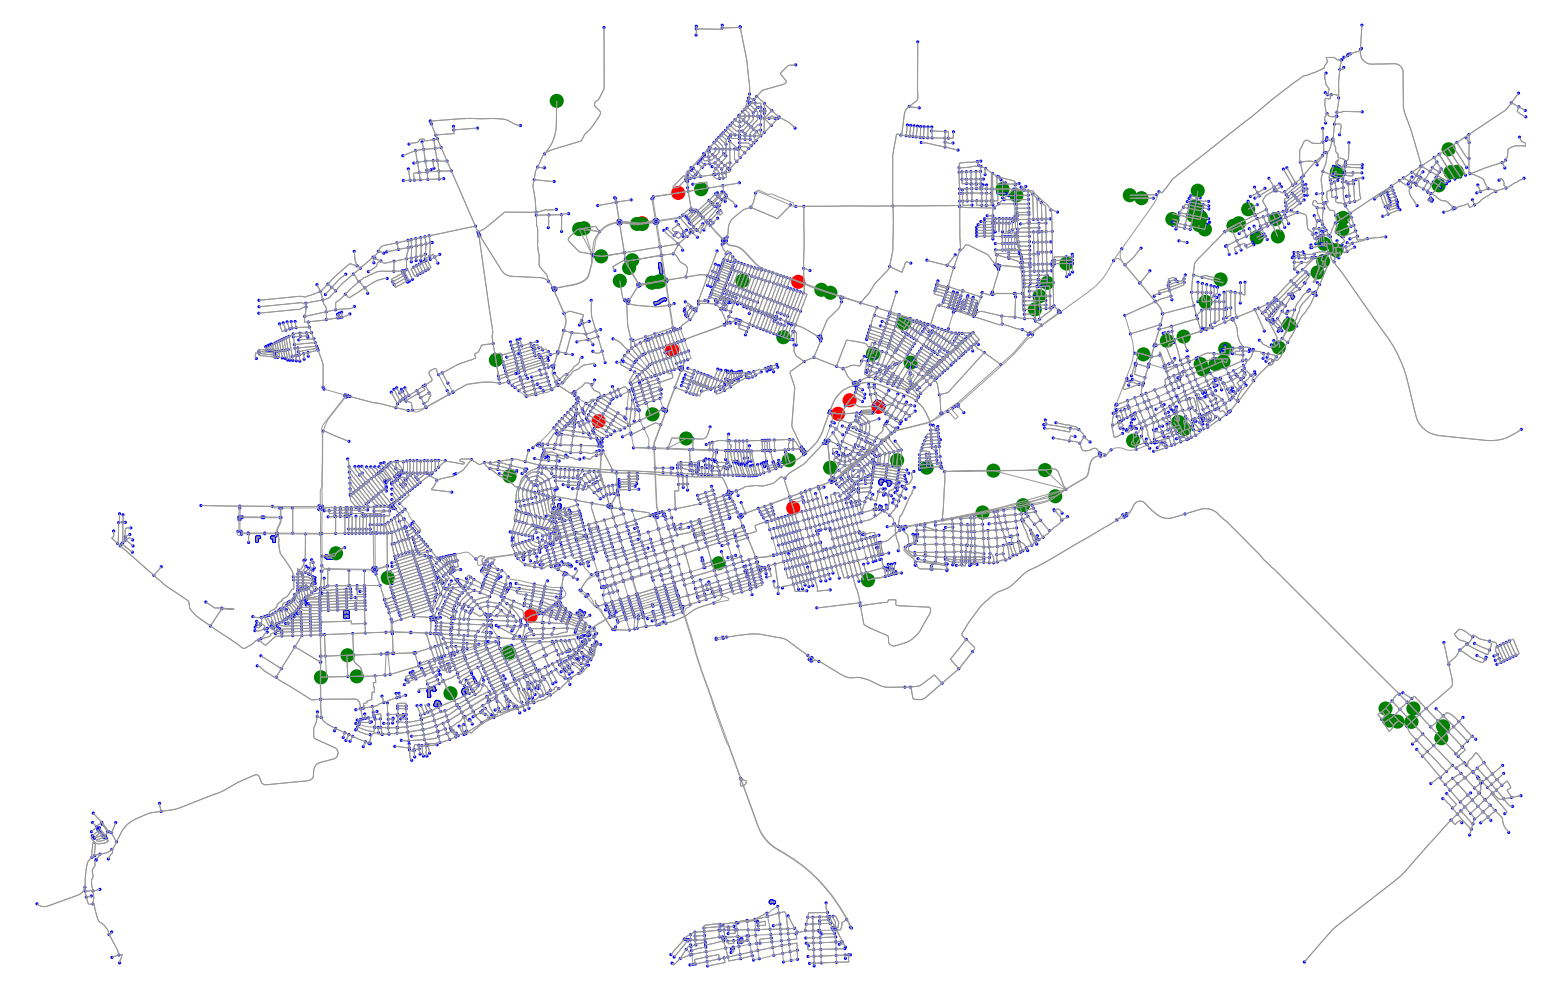

<Figure size 432x288 with 0 Axes>

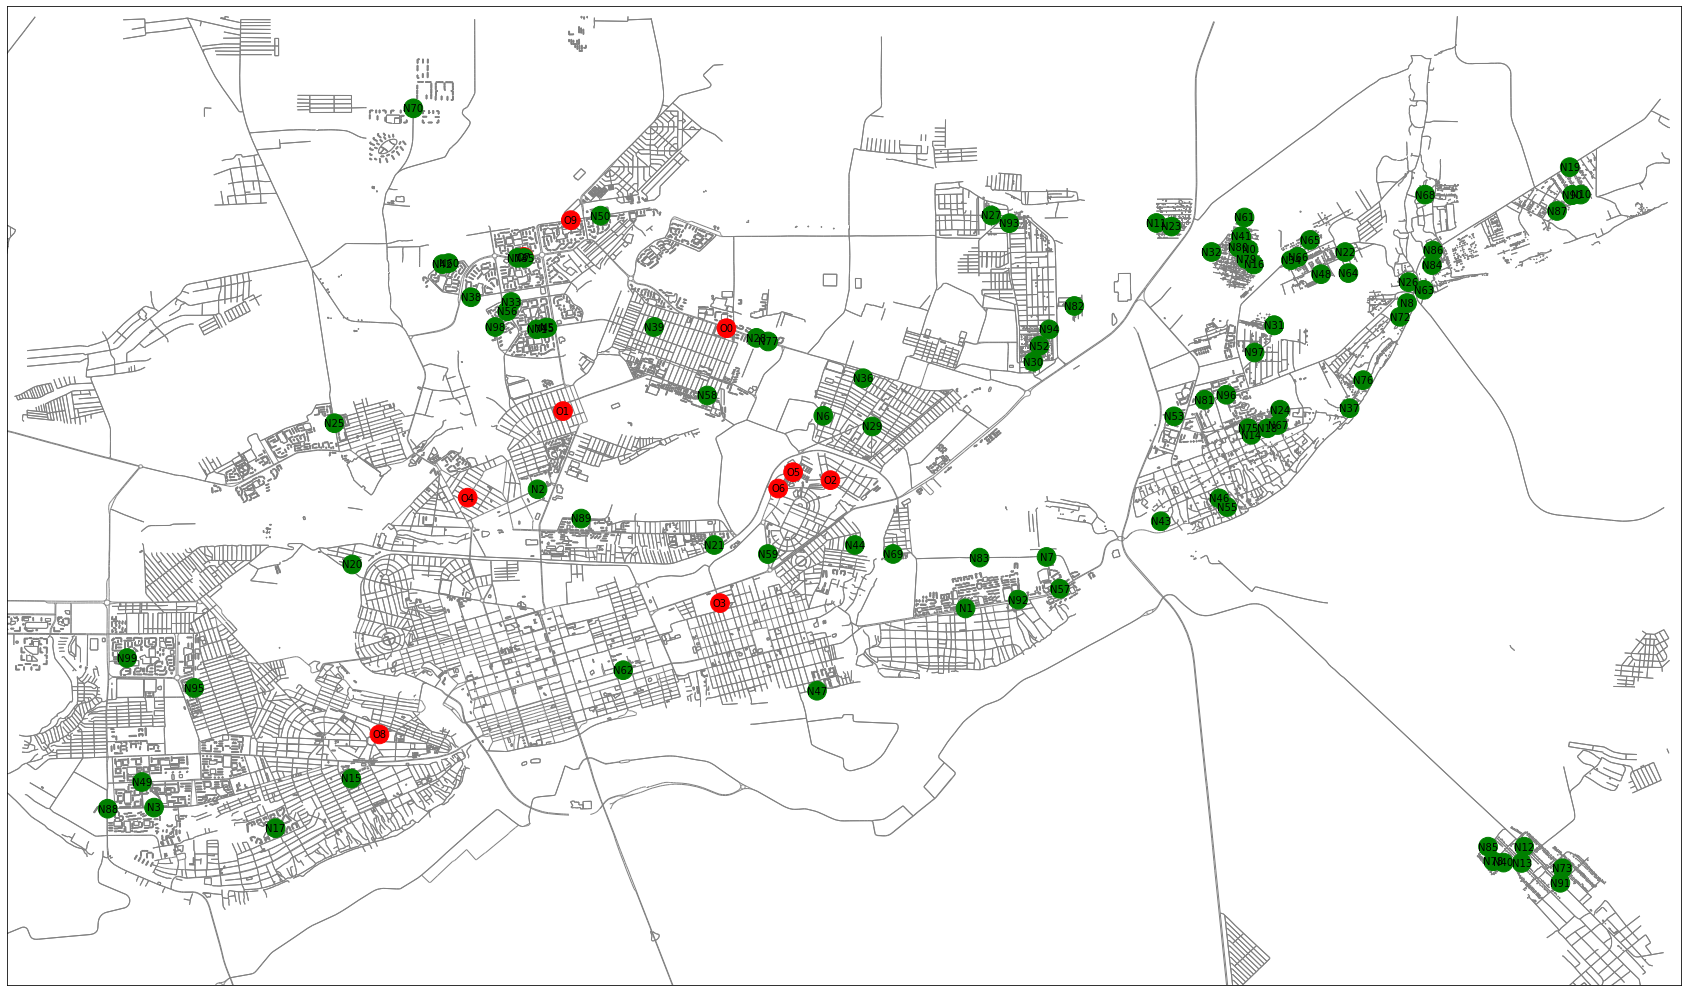

In [319]:
G = get_resulting_graph(G, c_obj, c_nodes, True, True)

In [321]:
graph_df = packing(G)

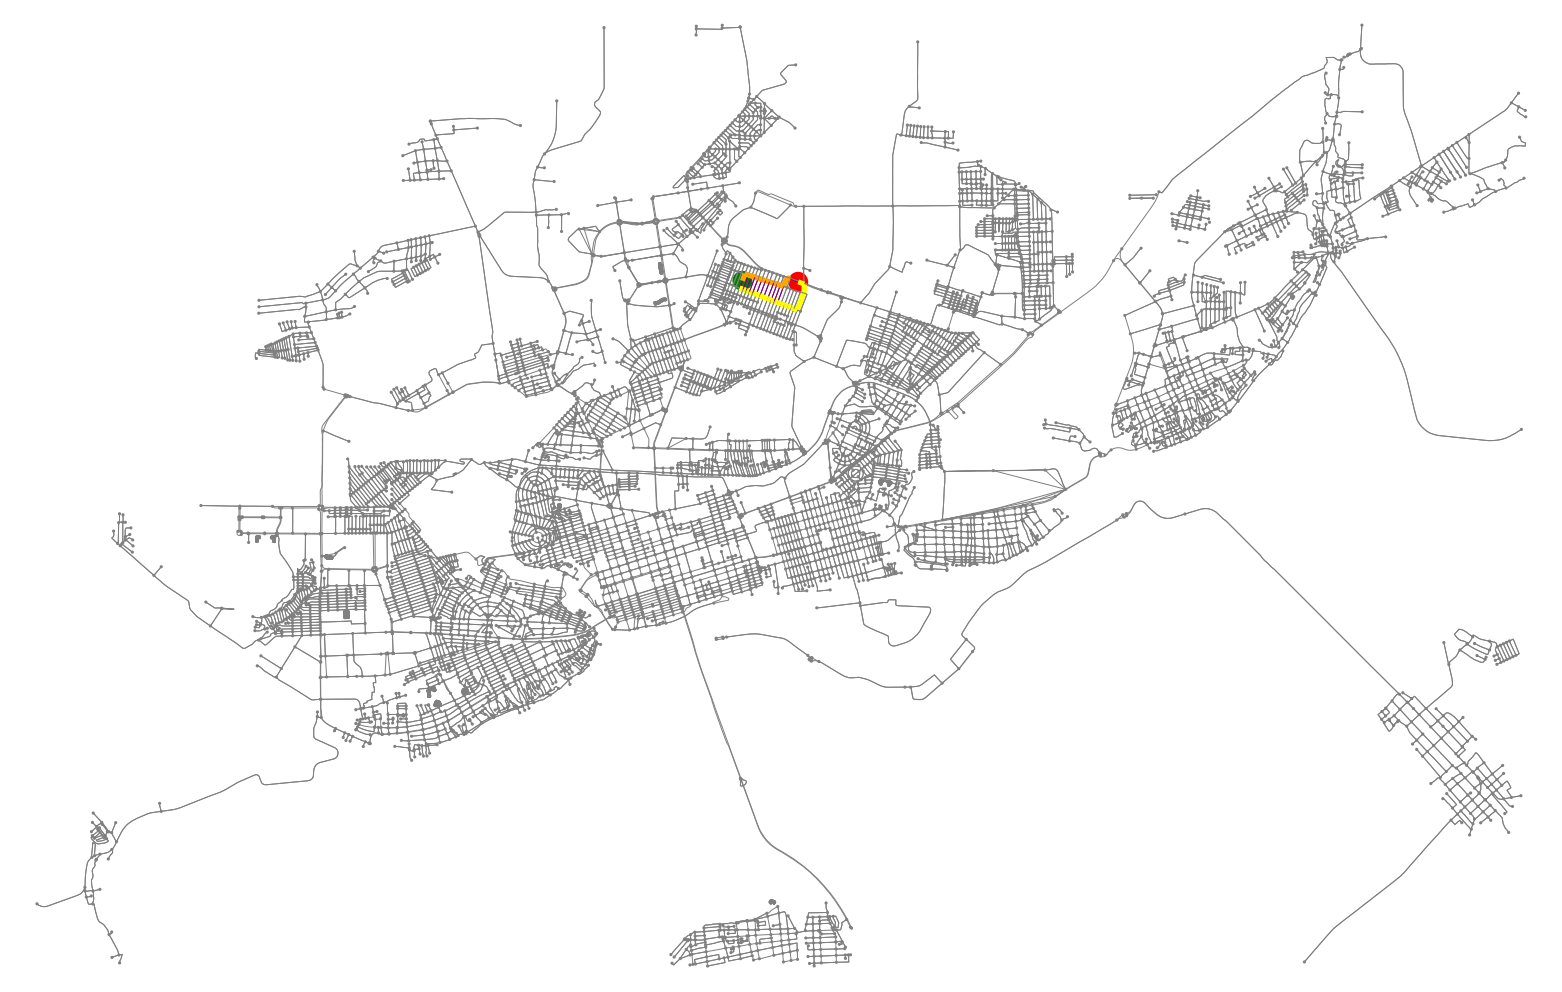

(39, (0, 1.5529694730088628), (0, 2.3073730745531265), (0, 3.8603425475619892))

In [352]:
get_path(G, graph_df, 39, c_obj, c_nodes)